In [152]:

import os
import pandas as pd
import yaml
import csv

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns

sns.set_theme()

In [153]:
# root_dir = r".\results\2024Apr11-215305_configs" # adam
root_dir = r".\results\2024Apr13-153634_configs" # sgd


In [154]:
def collect_experiment_data(root_dir):
    """
    Collects experiment data and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected data and parameters.
    """
    all_data = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("loss_record.csv"):
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the loss record CSV file
                df = pd.read_csv(file_path)

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                # Extract needed parameters
                run_id = cfg_data.get("run_id")
                tau = cfg_data["tau"]
                min_samples = cfg_data["min_samples"]

                # Add parameters as new columns to the DataFrame
                df["run_id"] = run_id
                df["tau"] = tau
                df["min_samples"] = min_samples

                # Append to the list of all data
                all_data.append(df)

    # Concatenate all data into a single DataFrame
    return pd.concat(all_data, ignore_index=True)


combined_data = collect_experiment_data(root_dir)
combined_data

aggregated_df = (
    combined_data.groupby(["run_id", "tau", "min_samples"])
    .agg({"epoch": "max"})
    .reset_index()
)

aggregated_df

,run_id,tau,min_samples,epoch
0,0,0.001,10,29
1,0,0.010,10,29
2,0,0.100,10,29
3,0,1.000,10,29
4,1,0.001,10,29
...,...,...,...,...
75,18,1.000,10,29
76,19,0.001,10,29
77,19,0.010,10,29
78,19,0.100,10,29


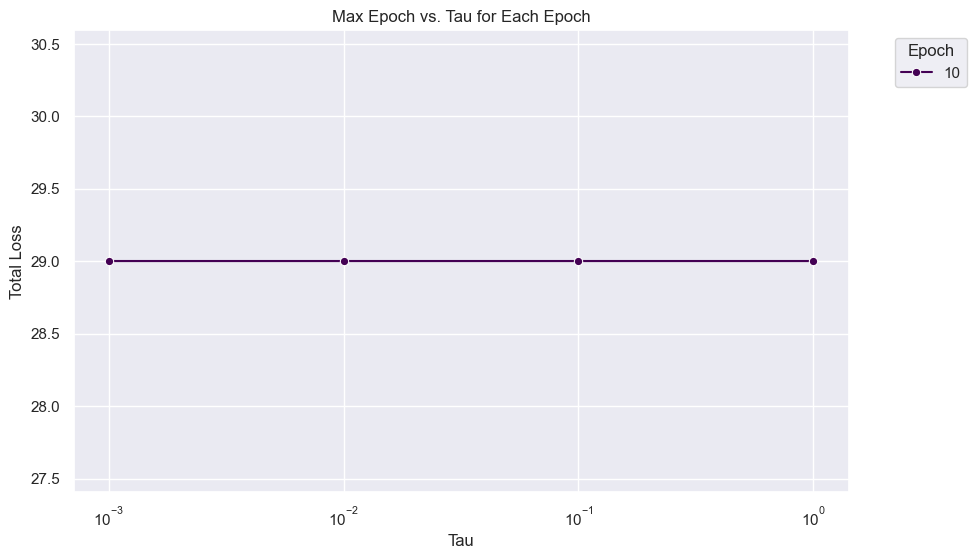

In [155]:
plt.figure(figsize=(10, 6))
# Assuming you want to plot the loss for the last epoch of each run, you can filter or aggregate the data as needed
sns.lineplot(
    data=aggregated_df,
    x="tau",
    y="epoch",
    hue="min_samples",
    palette="viridis",
    marker="o",
)
plt.xlabel("Tau")
plt.ylabel("Total Loss")
plt.xscale("log")
# plt.yscale('log')
plt.title("Max Epoch vs. Tau for Each Epoch")
plt.legend(title="Epoch", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [156]:
def collect_bellman_errors(root_dir):
    """
    Collects Bellman error values and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected Bellman errors and parameters.
    """
    all_errors = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file == "bellman_error.csv":
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the Bellman error values from the CSV file
                with open(file_path, "r") as error_file:
                    csv_reader = csv.reader(error_file)
                    headers = next(csv_reader)  # Skip header row
                    values = next(csv_reader)  # Get the values

                # Map the values to their corresponding headers
                bellman_errors = dict(zip(headers, values))
                validation_error = float(bellman_errors['validation_error'])
                training_error = float(bellman_errors['training_error'])

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                # Extract needed parameters
                run_id = cfg_data.get("run_id")
                tau = cfg_data["tau"]
                min_samples = cfg_data["min_samples"]

                # Create a dictionary with the collected data
                error_data = {
                    "run_id": run_id,
                    "tau": tau,
                    "min_samples": min_samples,
                    "validation_error": validation_error,
                    "training_error": training_error
                }

                # Append to the list of all errors
                all_errors.append(error_data)

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(all_errors)


# Example usage
bellman_errors_df = collect_bellman_errors(root_dir)
bellman_errors_df



,run_id,tau,min_samples,validation_error,training_error
0,0,0.001,10,0.000547,0.001900
1,1,0.001,10,0.004237,0.000745
2,10,0.001,10,NaN,NaN
3,11,0.001,10,NaN,NaN
4,12,0.001,10,0.017354,0.004208
...,...,...,...,...,...
75,5,1.000,10,NaN,NaN
76,6,1.000,10,NaN,NaN
77,7,1.000,10,NaN,NaN
78,8,1.000,10,NaN,NaN


In [157]:
bellman_errors_df_melted = pd.melt(bellman_errors_df, id_vars=['run_id', 'tau', 'min_samples'], value_vars=['validation_error', 'training_error'], var_name='error_type', value_name='error_value')
bellman_errors_df_melted

,run_id,tau,min_samples,error_type,error_value
0,0,0.001,10,validation_error,0.000547
1,1,0.001,10,validation_error,0.004237
2,10,0.001,10,validation_error,NaN
3,11,0.001,10,validation_error,NaN
4,12,0.001,10,validation_error,0.017354
...,...,...,...,...,...
155,5,1.000,10,training_error,NaN
156,6,1.000,10,training_error,NaN
157,7,1.000,10,training_error,NaN
158,8,1.000,10,training_error,NaN


In [158]:
# # bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["tau"]!=0.01]
# bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["min_samples"] != 0]

In [159]:
# bellman_errors_df_filtered["min_samples"] = bellman_errors_df_filtered[
#     "min_samples"
# ].astype(str)

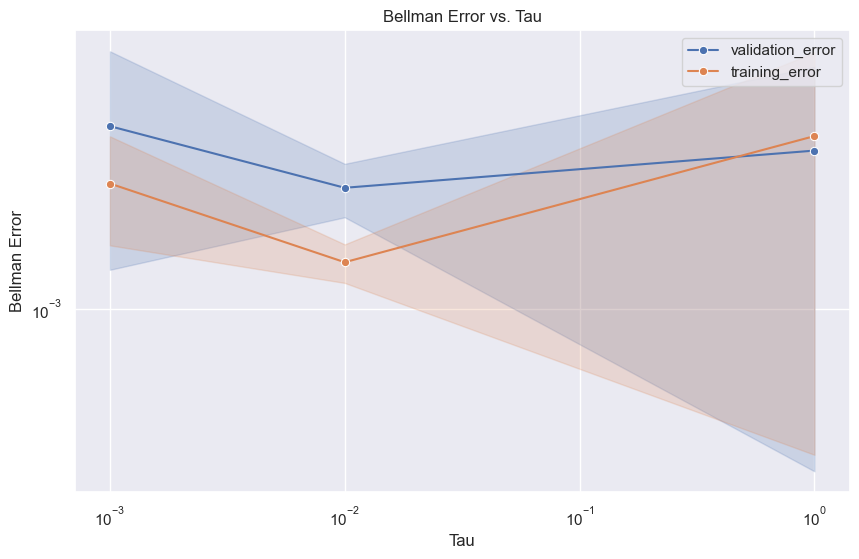

In [160]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bellman_errors_df_melted,
    x="tau",
    y="error_value",
    hue="error_type",
    marker="o",
    # errorbar=("pi", 100),
    errorbar="ci"
    # label="Bellman Error",
)
plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")
plt.legend()
plt.show()

In [161]:
# baseline_dir = r".\results\2024Apr12-105805_baseline_configs" # adam
baseline_dir = r".\results\2024Apr13-154845_baseline_configs" # sgd

baseline_errors_df = collect_bellman_errors(baseline_dir)
baseline_errors_df


,run_id,tau,min_samples,validation_error,training_error
0,0,1,10,NaN,NaN
1,1,1,10,NaN,NaN
2,10,1,10,NaN,NaN
3,11,1,10,NaN,NaN
4,12,1,10,NaN,NaN
5,13,1,10,NaN,NaN
6,14,1,10,NaN,NaN
7,15,1,10,NaN,NaN
8,16,1,10,NaN,NaN
9,17,1,10,0.000134,0.000962


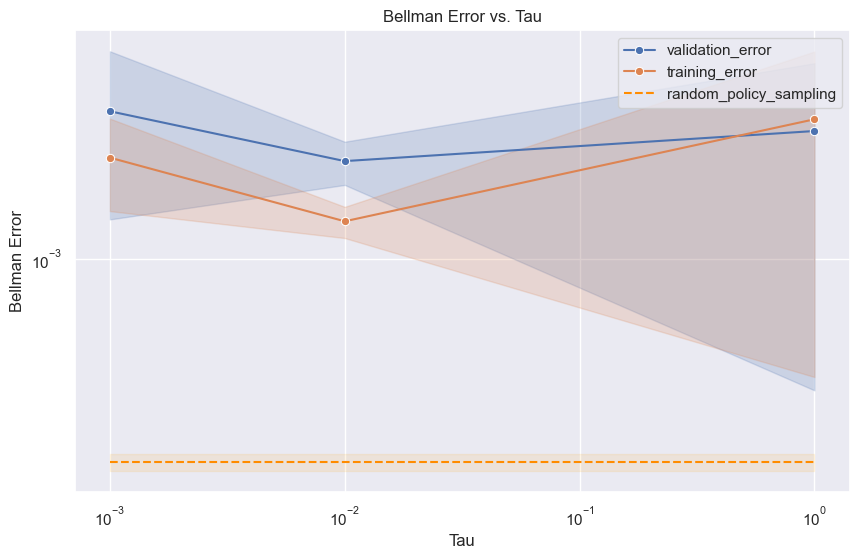

In [162]:
baseline_avg_bellman_error = baseline_errors_df['validation_error'].mean()
baseline_std_dev = baseline_errors_df['validation_error'].std()

plt.figure(figsize=(10, 6))

# Plot experiment data
sns.lineplot(
    data=bellman_errors_df_melted,
    x="tau",
    y="error_value",
    hue="error_type",
    marker="o",
    # errorbar=("pi", 100),
    errorbar="ci"
    # label="Bellman Error",
)

tau_min = bellman_errors_df['tau'].min()
tau_max = bellman_errors_df['tau'].max()

log_tau_min, log_tau_max = np.log10(tau_min), np.log10(tau_max)
plt.plot([10**log_tau_min, 10**log_tau_max], [baseline_avg_bellman_error, baseline_avg_bellman_error], linestyle='--', color='darkorange')

# Add standard deviation as a confidence interval around the baseline
plt.fill_between([tau_min, tau_max], 
                 [baseline_avg_bellman_error - baseline_std_dev]*2, 
                 [baseline_avg_bellman_error + baseline_std_dev]*2, 
                 color='orange', alpha=0.1, label='random_policy_sampling')

# Adjustments to plot aesthetics
plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")

# Get the current handles and labels from the plot
handles, labels = plt.gca().get_legend_handles_labels()

# Create a custom handle for the dark orange dotted line
custom_handle = Line2D([], [], color='darkorange', linestyle='--', label='random_policy_sampling')

# Replace the handle for 'random_policy_sampling' with the custom handle
# This assumes 'random_policy_sampling' is the last added label/handle. Adjust if needed.
new_handles = [h for h, l in zip(handles, labels) if l != 'random_policy_sampling'] + [custom_handle]
new_labels = [l for l in labels if l != 'random_policy_sampling'] + ['random_policy_sampling']

# Create the updated legend with the custom handle
plt.legend(new_handles, new_labels)

plt.show()


In [163]:
specific_tau = 1  # Set the specific tau value you are interested in
filtered_df = bellman_errors_df_melted[bellman_errors_df_melted['tau'] == specific_tau]

baseline_melted = pd.melt(baseline_errors_df, id_vars=['run_id', 'tau', 'min_samples'], value_vars=['validation_error', 'training_error'], var_name='error_type', value_name='error_value')
baseline_melted['source'] = 'Baseline'  # Add a source column to indicate these are from baseline
# baseline_melted['error_type'] = baseline_melted['error_type'].replace({'validation_error': 'Validation', 'training_error': 'Training'})  # Rename for clarity

# Assuming df1 is your experimental data and already melted
filtered_df['source'] = 'Experiment'  # Indicate these are experimental data

# Combine the two datasets
combined_df = pd.concat([filtered_df, baseline_melted], ignore_index=True)
combined_df

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_21168\1692046549.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['source'] = 'Experiment'  # Indicate these are experimental data


,run_id,tau,min_samples,error_type,error_value,source
0,0,1.0,10,validation_error,NaN,Experiment
1,1,1.0,10,validation_error,NaN,Experiment
2,10,1.0,10,validation_error,NaN,Experiment
3,11,1.0,10,validation_error,0.006532,Experiment
4,12,1.0,10,validation_error,NaN,Experiment
...,...,...,...,...,...,...
75,5,1.0,10,training_error,NaN,Baseline
76,6,1.0,10,training_error,NaN,Baseline
77,7,1.0,10,training_error,0.001205,Baseline
78,8,1.0,10,training_error,NaN,Baseline


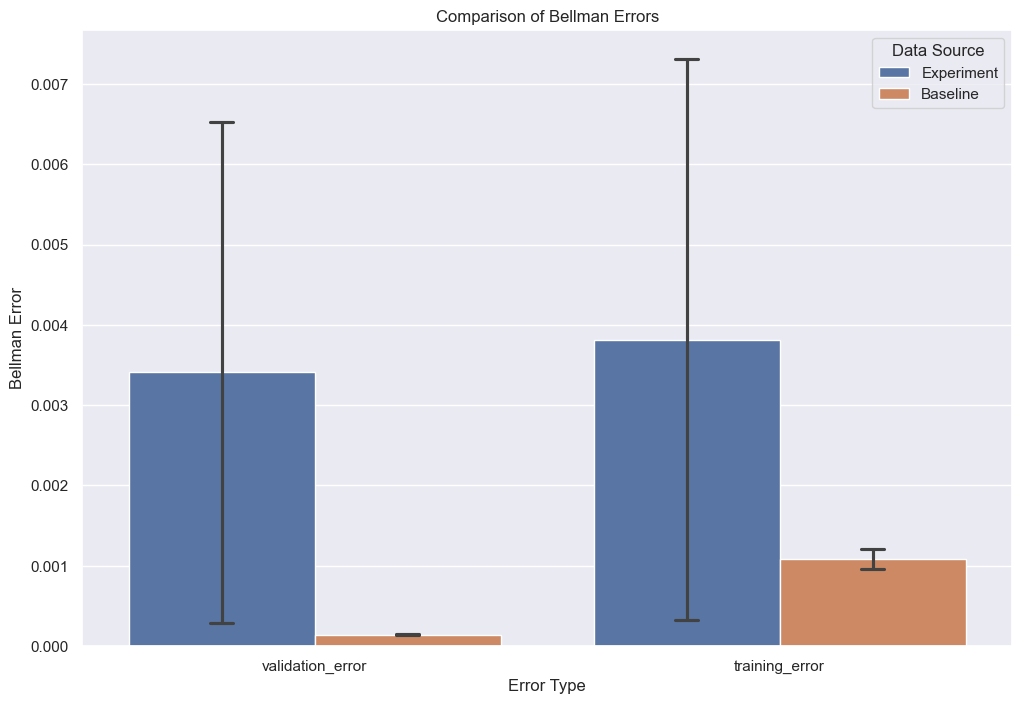

In [164]:
plt.figure(figsize=(12, 8))
sns.barplot(data=combined_df, x='error_type', y='error_value', hue='source', capsize=.1)

# Adding labels and titles
plt.xlabel("Error Type")
plt.ylabel("Bellman Error")
plt.title("Comparison of Bellman Errors")
plt.legend(title="Data Source")

plt.show()

In [165]:
# use mdp to generate transition distribution
# this generates another dataset of transitions

# then apply:
# ### Training
# input_size = len(states[0])  # Or another way to represent the size of your input
# output_size = len(actions)

# # Initialize the DQN
# dqn = DQN(input_size, output_size)

# loss_record = train_dqn(
#     dqn,
#     sampled_transitions_train,
#     Q_pi_random,
#     states,
#     actions,
#     gamma,
#     epsilon,
#     batch_size=batch_size,
#     max_iterations=train_max_iterations,
#     logger=logger,
# )

# bm_error = compute_bellmans_error(
#     dqn, validation_transitions=transitions_val, gamma=gamma
# )

### AND

# policy evaluation

# plot both

In [166]:
# do policy evaluation on train datasets -> Q
# Evaluate with Q on validation set

# training DQN == value iteration
# we want to do policy evaluation with DQN (we do this by changing the loss function with bellman equation for Q pi instead of Q*)
# if we want to do early stopping, do it with Q* instead of Q pi random